<a href="https://colab.research.google.com/github/gitorivera/sneia-lectures/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

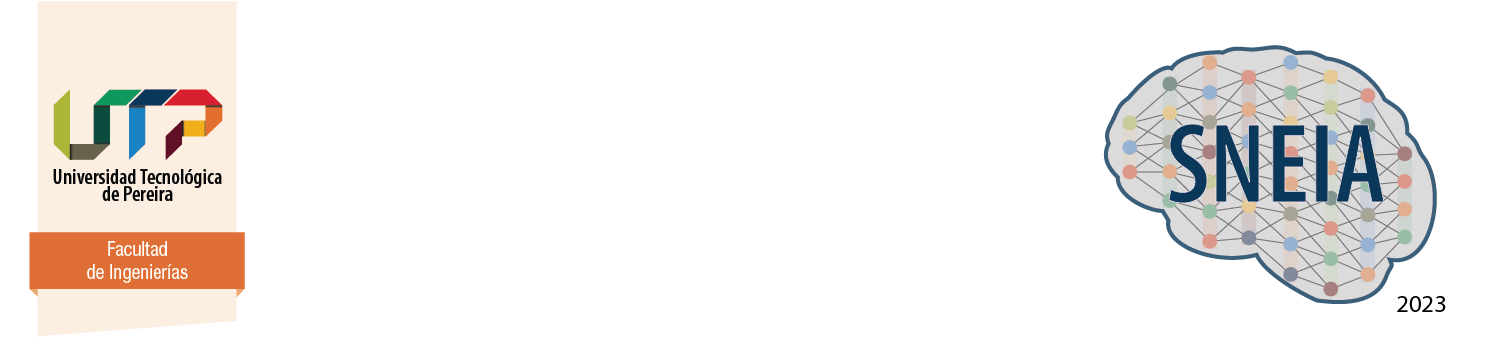

# Transfer Learning
En este notebook se utiliza el concepto de transfer learning para utilizar un modelo pre-entrenado, para resolver una tarea de clasificación multiclase como es el fashion Mnist.

In [22]:
import os
import zipfile
from tensorflow import keras
from keras import layers
from keras import Model
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3


## Preconfiguracón del modelo
Para utilizar los modelos, se deben realizar unos pasos previos de configuración. Para los modelos incluidos en Keras, los pasos son 2:


1.   Descarga de los pesos
2.   Configuración del modelo

### Descarga de los pesos
Descargamos los pesos, y asignamos la ruta a una variable


In [23]:
# Descargar los pesos de los modelos
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
# Guardamos los pesos en una variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


--2023-11-16 23:09:29--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.207, 142.251.8.207, 142.251.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  26.0MB/s    in 3.6s    

2023-11-16 23:09:34 (23.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



### Configuración del modelo pre-entrenado
En la etapa de configuración del modelo pre-entrenado definimos la forma de la entrada, definimos los pesos que usaremos, al igual como las capas que usaremos del modelo. Se puede escoger cualquier capa del modelo, como última capa.

In [24]:
# Importar modelo ya entrenado sin incluir sus pesos ni su clasificador (Esencial para cambiar el objetivo del modelo)
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

# Agregar pesos descargados al modelo importado
pre_trained_model.load_weights(local_weights_file)

# Indicar que no se quieren hacer cambios en las primeras capas del modelo
for layer in pre_trained_model.layers:
  layer.trainable = False

# Resumen del modelo hasta ahora
pre_trained_model.summary()

# Guardar la ultima capa del modelo para conectarlo con el nuevo clasificador
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_376 (Conv2D)         (None, 74, 74, 32)           864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_376 (B  (None, 74, 74, 32)           96        ['conv2d_376[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_376 (Activation  (None, 74, 74, 32)           0         ['batch_normalizati

## Construcción del resto de la red
La construcción del resto de la red neuronal se hace de la misma manera.

In [25]:
# Creamos un nuevo clasificador para la tarea especifica que vamos a realizar en base a la ultima capa del modelo
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense  (1, activation='sigmoid')(x)

# Agregamos el nuevo clasificador al modelo importado
model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

## Preprocesamiento de los datos
Se preprocesan los datos para ser alimentados a la red neuronal

In [26]:
# Descargar base de datos para nueva tarea a realizar
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

# Extraer archivo y definir la carpeta donde esta guardado
local_zip = '//tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
base_dir = '/tmp/cats_and_dogs_filtered'

# Crear carpeta para guardar los datos de entrenamiento y validacion
train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Crear subcarpetas para las 2 categorias de entrenamiento
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Determinar etiquetas
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Generacion de datos
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. ) # Note that the validation data should not be augmented!

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))

--2023-11-16 23:09:57--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.207, 142.251.8.207, 142.251.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  22.7MB/s    in 2.9s    

2023-11-16 23:10:01 (22.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Entrenamos el modelo


In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50)

Epoch 1/20
 43/100 [===========>..................] - ETA: 1:24 - loss: 0.2289 - accuracy: 0.8942